# Multiple Mask Augmentation Using the DataPipeline

In this notebook we demonstrate augmenting an image that has several masks. This is done using a the `DataPipeline` class which is a new class that handles images passed as array data and returns images as array data. It does not read images from the disk drive or save images to the disk drive.

### Note:

**This is beta functionality and will be incorporated into the standard Pipeline at a later date, once its functionality has reach maturity.** For now, multiple mask augmentation works only with the `DataPipeline` class. The `DataPipeline` class contains all the image operations of the standard `Pipeline` class, such as `rotate()`, `zoom()`, and so on.

## Images and Masks

Let's first take a look at an example problem where you might need to augment an image and two mask images identically.

Say for example you had a dataset of skin lesions and corresponding mask images. The original image and the two masks look like the following:

| Original | Mask 1 | Mask 2 |
|----------|--------|--------|
| ![Original](https://raw.githubusercontent.com/mdbloice/AugmentorFiles/master/Notebook-Images/Masks-Example/original/ISIC_0000000.jpg) | ![Segmentation](https://raw.githubusercontent.com/mdbloice/AugmentorFiles/master/Notebook-Images/Masks-Example/segmentation/ISIC_0000000_Segmentation.png) | ![Pigment](https://raw.githubusercontent.com/mdbloice/AugmentorFiles/master/Notebook-Images/Masks-Example/pigment-network/ISIC_0000000_attribute_pigment_network.png) |

*Images from* <https://challenge2018.isic-archive.com/>

The `DataPipeline` object expects a multi-dimensional data structure in the following format.

A list, in this case named `images`, containing images and masks grouped into their own lists. 

For example, `images` may look like the following:

```python
images = [
    [im_1, mask_1_a, mask_1_b],
    [im_2, mask_2_a, mask_2_b],
    ...,
    [im_n, mask_n_a, mask_n_b]
]
```

Where each element in `images` is a list containing the images that are grouped, e.g. an original image, and two mask images as in the example above.

## Preparing a Data Structure for Augmentation

Organising your images into the format/structure described above is quite simple. 

For example, let's say you have some original images that are contained in a folder name `ground_truth` and the masks are contained in folders called `segmentation-masks` and `pigment-network-masks` respectively, one could do the following by first reading and sorting the lists of images contained in their directories:

In [1]:
# Some imports we will need for this notebook
import Augmentor
import numpy as np
from PIL import Image
import glob
from natsort import natsorted
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Reading and sorting the image paths from the directories
ground_truth_images = natsorted(glob.glob("./im/original/*.jpg"))
segmentation_mask_images = natsorted(glob.glob("./im/segmentation/*.png"))
pigment_network_mask_images = natsorted(glob.glob("./im/pigment-network/*.png"))

We read the images from the directory using `glob` and use `natsorted` to sort the images in a way so that their order corresponds to each image or mask in each list:

In [2]:
for i in range(0, len(ground_truth_images)):
    print("Set %s: Ground truth: %s | Mask 1: %s | Mask 2: %s" % 
          (i+1, os.path.basename(ground_truth_images[i]),
           os.path.basename(segmentation_mask_images[i]),
           os.path.basename(pigment_network_mask_images[i])))

Set 1: Ground truth: ISIC_0000000.jpg | Mask 1: ISIC_0000000_Segmentation.png | Mask 2: ISIC_0000000_attribute_pigment_network.png
Set 2: Ground truth: ISIC_0000001.jpg | Mask 1: ISIC_0000001_Segmentation.png | Mask 2: ISIC_0000001_attribute_pigment_network.png
Set 3: Ground truth: ISIC_0000006.jpg | Mask 1: ISIC_0000006_Segmentation.png | Mask 2: ISIC_0000006_attribute_pigment_network.png
Set 4: Ground truth: ISIC_0000007.jpg | Mask 1: ISIC_0000007_Segmentation.png | Mask 2: ISIC_0000007_attribute_pigment_network.png
Set 5: Ground truth: ISIC_0000008.jpg | Mask 1: ISIC_0000008_Segmentation.png | Mask 2: ISIC_0000008_attribute_pigment_network.png
Set 6: Ground truth: ISIC_0000009.jpg | Mask 1: ISIC_0000009_Segmentation.png | Mask 2: ISIC_0000009_attribute_pigment_network.png


As you can see, there are 6 sets of images. Each set contains the original image and two mask images.

To make it easier to create and data structure, we can use `zip` to collate the three lists:

In [3]:
collated_images_and_masks = zip(ground_truth_images, segmentation_mask_images, pigment_network_mask_images)
collated_images_and_masks

[('./im/original/ISIC_0000000.jpg',
  './im/segmentation/ISIC_0000000_Segmentation.png',
  './im/pigment-network/ISIC_0000000_attribute_pigment_network.png'),
 ('./im/original/ISIC_0000001.jpg',
  './im/segmentation/ISIC_0000001_Segmentation.png',
  './im/pigment-network/ISIC_0000001_attribute_pigment_network.png'),
 ('./im/original/ISIC_0000006.jpg',
  './im/segmentation/ISIC_0000006_Segmentation.png',
  './im/pigment-network/ISIC_0000006_attribute_pigment_network.png'),
 ('./im/original/ISIC_0000007.jpg',
  './im/segmentation/ISIC_0000007_Segmentation.png',
  './im/pigment-network/ISIC_0000007_attribute_pigment_network.png'),
 ('./im/original/ISIC_0000008.jpg',
  './im/segmentation/ISIC_0000008_Segmentation.png',
  './im/pigment-network/ISIC_0000008_attribute_pigment_network.png'),
 ('./im/original/ISIC_0000009.jpg',
  './im/segmentation/ISIC_0000009_Segmentation.png',
  './im/pigment-network/ISIC_0000009_attribute_pigment_network.png')]

Now we read these as arrays into a data structure that can be read by `DataPipeline` using a nested list comprehension for brevity: 

In [4]:
images = [[np.asarray(Image.open(y)) for y in x] for x in collated_images_and_masks]

We can now generate a list of labels for this example of length 6 as there are 6 images:

In [5]:
y = [0,1,0,1,0,1]

We can preview the images using Matplotlib's `imshow()` function now that they are structured into the `images` data structure:

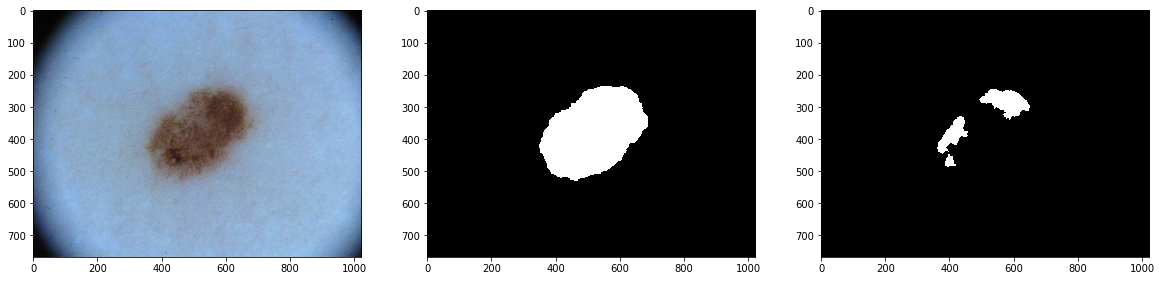

In [6]:
r_index = random.randint(0, len(images)-1)
f, axarr = plt.subplots(1, 3, figsize=(20,15))
axarr[0].imshow(images[r_index][0])
axarr[1].imshow(images[r_index][1], cmap="gray")
axarr[2].imshow(images[r_index][2], cmap="gray");  # Semi-colon to supress Matplotlib text output

## Augment the Data

First we initialise a `DataPipeline` object.

### Initialising DataPipeline

Now we can intialise a `DataPipeline` object using out `images` data structure and `y` label list:

In [7]:
p = Augmentor.DataPipeline(images, y)

**Note:** If you do not require labels, simply omit the labels parameter, `y`, and use 

```python
p = Augmentor.DataPipeline(images)
```

passing only the `images` data stucture.

### Add Operations

First, let's add a few operations to the DataPipeline object, `p`:

In [8]:
p.rotate(1, max_left_rotation=5, max_right_rotation=5)
p.flip_top_bottom(0.5)
p.zoom_random(1, percentage_area=0.5)

A `DataPipeline` object can either return the augmented data using the `sample` method, similar to the standard `Pipeline` class, or it can return a generator. We will use both methods here.

Here we sample 10 images from the pipeline using the `sample()` method:

In [9]:
augmented_images, labels = p.sample(10)

And print a random group here to the notebook:

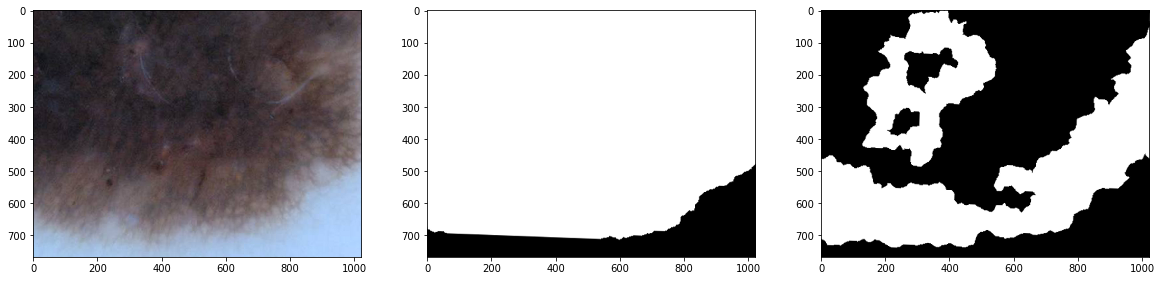

In [10]:
r_index = random.randint(0, len(augmented_images)-1)
f, axarr = plt.subplots(1, 3, figsize=(20,15))
axarr[0].imshow(augmented_images[r_index][0])
axarr[1].imshow(augmented_images[r_index][1], cmap="gray")
axarr[2].imshow(augmented_images[r_index][2], cmap="gray");  # Semi-colon to supress Matplotlib text output

### Using a Generator

Generators are created in a very similar way:

In [11]:
g = p.generator(batch_size=10)

Using the generator's `next()` function we can get a batch of 10 with labels.

In [13]:
augmented_images, labels = g.next()

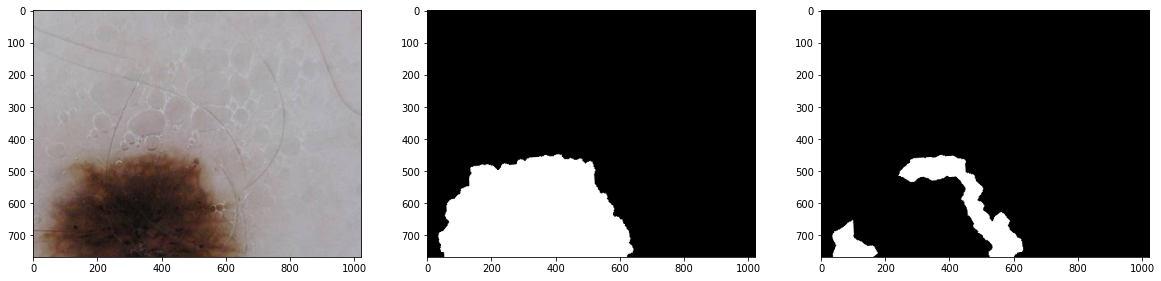

In [14]:
r_index = random.randint(0, len(augmented_images)-1)
f, axarr = plt.subplots(1, 3, figsize=(20,15))
axarr[0].imshow(augmented_images[r_index][0])
axarr[1].imshow(augmented_images[r_index][1], cmap="gray")
axarr[2].imshow(augmented_images[r_index][2], cmap="gray");  # Semi-colon to supress Matplotlib text output

Data generators return data indefinitely, as long as you call them. 